## Data Science Test

Please review all cells, following instructions for each and adding code and explaining your approach where appropriate.

The goal of this test is to observe your problem solving and the quality of your code, rather than looking for a particular single answer/solution.


April 2024

### Investigating  Data

In [2]:
import os
basepath = os.path.dirname(os.getcwd())
datapath = os.path.join(basepath, 'data', 'applemobilitytrends-2022-02-24.csv')

import sys
sys.path.append(basepath)

import polars as pl
import altair as alt
import matplotlib.pyplot as plt
from typing import List, Dict, Any, Union
import numpy as np
from datetime import date
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates 



from src.utils import extract_country_data, myjoin
from src.viz import plot_stack, plot_rolling_correlation, plot_weekonweek_diff
from src.model import LinearSplineModel, PassiveAggressiveSplineModel


alt.data_transformers.enable("vegafusion")

DataTransformerRegistry.enable('vegafusion')

In [3]:
##
# You will be using the apple mobility data set that should have been attached as a zipped csv along with this test.
# Read in the raw data, and filter out all but Denmark and Norway.
# Resample the time series data to weekly granularity, and determine if you think mobility between the two
# countries are correlated or not.

# Add code
# Briefly explain your conclusion about mobility correlation

In [4]:
data = pl.read_csv(datapath)

df_nor = extract_country_data(df=data, country='Norway', weekly_resample=True, agg_fun='mean')
df_den = extract_country_data(df=data, country='Denmark', weekly_resample=True, agg_fun='mean')

country_join = myjoin(df1=df_nor, 
                      df2=df_den, 
                      join_keys='date', 
                      suffixes=('_nor', '_den'))

In [5]:
plot_rolling_correlation(df=country_join, country_tag=['nor', 'den'], max_correlation_window=30)

alt.VConcatChart(...)

In [6]:
print('Overall correlation driving', f"{country_join.select(pl.corr('driving_nor', 'driving_den')).to_numpy()[0][0]:.2f}")
print('Overall correlation walking', f"{country_join.select(pl.corr('walking_nor', 'walking_den')).to_numpy()[0][0]:.2f}")
print('Overall correlation transit', f"{country_join.select(pl.corr('transit_nor', 'transit_den')).to_numpy()[0][0]:.2f}")
print('Overall correlation total', f"{country_join.select(pl.corr('total_nor', 'total_den')).to_numpy()[0][0]:.2f}")

Overall correlation driving 0.89
Overall correlation walking 0.93
Overall correlation transit 0.95
Overall correlation total 0.93


#### Conclusions
* Overall the two timeseries looks like correlated.
* Timeseries are initially correlated since the Dennmark and Norway reacted in the same way to Covid.
* By looking at the rolling correlation though it's evident that the timeseries correlation is strongly **time dependent** meaning that there are period where correlation of Mobility Index components drops.


In [7]:
##
# Take your weekly resampled data for both countries, and plot it broken up into the three types of mobility.
# Now add week-on-week changes to the plot, using a 2nd axis. Also include the results of your 
# correlation investigation in the previous cell.

# Add code

In [8]:
plot_weekonweek_diff(df1 = df_nor, df2 = df_den, label1='Norway', label2='Denmark')

alt.HConcatChart(...)

In [9]:
##
# Repeat the above two exercises, but now for Italy and the United States. 

# Add code
# Comment briefly on the differences between the two correlation comparisons and what might cause them

In [10]:
df_us = extract_country_data(df=data, country='United States', weekly_resample=True, agg_fun='mean')
df_it = extract_country_data(df=data, country='Italy', weekly_resample=True, agg_fun='mean')

country_join_2 = myjoin(df1=df_us, 
                        df2=df_it, 
                        join_keys='date', 
                        suffixes=('_usa', '_ita'))

In [11]:
plot_rolling_correlation(df=country_join_2, country_tag=['usa', 'ita'], max_correlation_window=30)

alt.VConcatChart(...)

In [12]:
print('Overall correlation driving', f"{country_join_2.select(pl.corr('driving_usa', 'driving_ita')).to_numpy()[0][0]:.2f}")
print('Overall correlation walking', f"{country_join_2.select(pl.corr('walking_usa', 'walking_ita')).to_numpy()[0][0]:.2f}")
print('Overall correlation transit', f"{country_join_2.select(pl.corr('transit_usa', 'transit_ita')).to_numpy()[0][0]:.2f}")
print('Overall correlation total', f"{country_join_2.select(pl.corr('total_usa', 'total_ita')).to_numpy()[0][0]:.2f}")

Overall correlation driving 0.85
Overall correlation walking 0.86
Overall correlation transit 0.90
Overall correlation total 0.92


In [13]:
plot_weekonweek_diff(df1 = df_us, df2 = df_it, label1='United States', label2='Italy')

alt.HConcatChart(...)

#### Conclusions
Main difference between Nor-vs-Den and Ita-vs-Usa are:
* Italy is the first country in Europe that applied restriction to covid, earlier than Us. Norway and Denmark applied restriction in the same period.
* Norway and Denmark are very close geografically, this means that even weather is highly correlated. This is not true for Italy and Usa
* Norway and Denmark are similar in terms of public transport, cars distribution, transportation culture (**This is just an euristic, I don't have data**).
* In the summer Italian and American population moves very differently during holidays and in different time periods, mostly due to welfare and weather (**this is also an euristic**)

### Modelling with Data

In [14]:
##
# Take the data from the United States, and prepare it for modelling... if any "choices" need to be made during the 
# clean-up process, briefly describe the options and why you chose the one you did.  

# Add code
# Describe choices in the clean up step

#### Cleanup choices
* Ignore data before May 2020. Covid event is an extreme event and I will treat it as outlier
* Make data end on Sunday, so that the week is complete. This means exclude last daily sample. 

In [15]:
df_us = extract_country_data(data, 'United States', weekly_resample=True, agg_fun = 'mean')

df_us_cleanup = df_us.filter(
    pl.col('date') >= pl.datetime(2020, 5, 15),  # Filter out data before May 2020
    pl.col('date') <= pl.datetime(2022, 2, 7)  
)

Text(0.5, 1.0, 'US Mobility Trends')

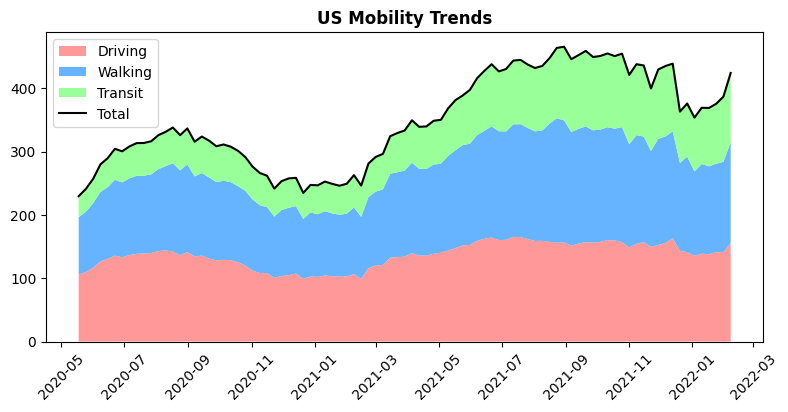

In [16]:
plt.figure(figsize=(8, 4))
plot_stack(df_us_cleanup, 'date', ['driving', 'walking', 'transit'],
          total_y='total',
          labels=['Driving', 'Walking', 'Transit'],
          colors=['#ff9999', '#66b3ff', '#99ff99'])
plt.title('US Mobility Trends', fontweight='bold')

In [17]:
##
# Create a model that predicts the next week's average driving mobility in the US. Evaluate the accuracy of your model, 
# and briefly discuss whether it is a "good" model or not.

# Add code
# Add commentary on the quality of the model

#### Comments
* Dataset too small to apply deep-learning or complex machine learning models.

In [18]:
# Prepare dataset and add features for modeling
model_data = df_us_cleanup.with_columns(
    weekofyear=pl.col('date').dt.week(),
    timeindex=(pl.col("date") - pl.lit(date(2020, 1, 1))).dt.total_days(),
    driving_lag= pl.col('driving').shift(1),
    walking_lag= pl.col('walking').shift(1),
    transit_lag= pl.col('transit').shift(1),
    total_lag= pl.col('total').shift(1),
).drop_nulls()

In [19]:
# Initialize models
lsm = LinearSplineModel(formula='cc(weekofyear, df=5) + timeindex', fit_intercept=False)
lsm_ar = LinearSplineModel(formula='cc(weekofyear, df=5) + timeindex + total_lag', fit_intercept=False)
pa_sm = PassiveAggressiveSplineModel(formula='cc(weekofyear, df=5) + timeindex + total_lag', C=0.000001)

In [20]:
# Fix and predict on validation
X_train, X_online = train_test_split(model_data, test_size=0.1, shuffle=False)

lsm.fit(X_train, X_train['total'])
lsm_ar.fit(X_train, X_train['total'])
pa_sm.fit(X_train, X_train['total'])

y_pred = lsm.predict(X_online, index='date')
y_pred_ar = lsm_ar.predict(X_online, index='date')
y_pred_pa = pa_sm.online_predict(X_online, X_online['total'], index='date')

y_pred_insample = lsm.predict(X_train, index='date')
y_pred_ar_insample = lsm_ar.predict(X_train, index='date')

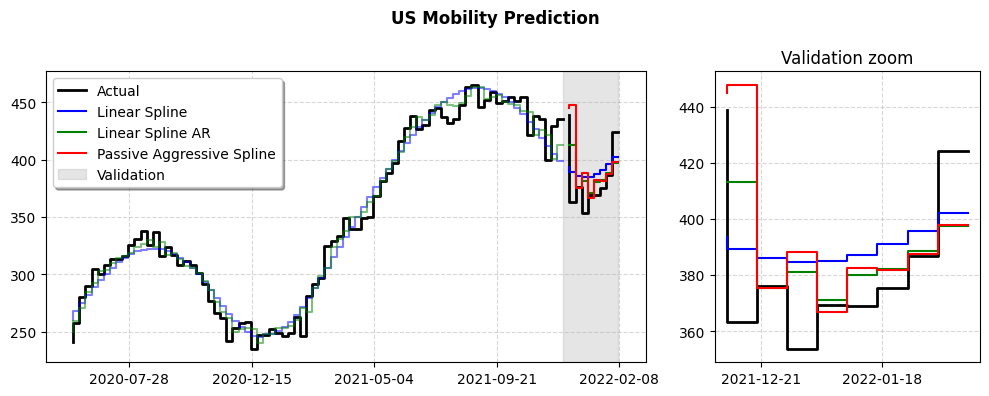

In [21]:
# ---------------------------------------- VISUALIZATION VALIDATION
fig=  plt.figure(figsize=(10, 4))

axtotal = plt.subplot2grid(shape=(1, 3), loc=(0, 0), colspan=2)
axzoom = plt.subplot2grid(shape=(1, 3), loc=(0, 2), colspan=1)

# Train
axtotal.step(X_train['date'], X_train['total'], color='black', linewidth=2)
axtotal.step(y_pred_insample['date'], y_pred_insample['pred'], color='blue', alpha=.5)
axtotal.step(y_pred_ar_insample['date'], y_pred_ar_insample['pred'], color='green', alpha=.5)

# Val
axtotal.step(X_online['date'], X_online['total'], label='Actual', color='black', linewidth=2)
axtotal.step(y_pred['date'], y_pred['pred'], label='Linear Spline', color='blue')
axtotal.step(y_pred_ar['date'], y_pred_ar['pred'], label='Linear Spline AR', color='green')
axtotal.step(y_pred_pa['date'], y_pred_pa['pred'], label='Passive Aggressive Spline', color='red')
axtotal.axvspan(X_train['date'].max(), X_online['date'].max(), color='gray', alpha=0.2, label='Validation')
axtotal.legend(shadow=True)
axtotal.grid(linestyle='--', alpha=0.5)
axtotal.xaxis.set_major_locator(mdates.WeekdayLocator(interval=20)) 
axtotal.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Val
axzoom.step(X_online['date'], X_online['total'], label='Actual', color='black', linewidth=2)
axzoom.step(y_pred['date'], y_pred['pred'], label='Linear Spline', color='blue')
axzoom.step(y_pred_ar['date'], y_pred_ar['pred'], label='Linear Spline AR', color='green')
axzoom.step(y_pred_pa['date'], y_pred_pa['pred'], label='Passive Aggressive Spline', color='red')
axzoom.grid(linestyle='--', alpha=0.5)
axzoom.set_title('Validation zoom')
axzoom.xaxis.set_major_locator(mdates.WeekdayLocator(interval=4)) 
axzoom.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

fig.suptitle('US Mobility Prediction', fontweight='bold')
plt.tight_layout()



In [22]:
# Performance
performance_data = (
    y_pred.rename({'pred': 'LinearModel'})
    .join(y_pred_ar.rename({'pred': 'LinearModelAR'}), on='date')
    .join(y_pred_pa.rename({'pred': 'PassiveAggressiveModel'}), on='date')
    .join(X_online.select(['date', 'total', 'total_lag']).rename({'total': 'Actual', 'total_lag': 'LagBaseline'}), on='date')
)

performance_table = pl.DataFrame(None)
for m in ['LinearModel', 'LinearModelAR', 'PassiveAggressiveModel', 'LagBaseline']:
    print(f'MSE for {m}:', performance_data.select(
        (pl.col(m) - pl.col('Actual')).abs().pow(2).mean().sqrt()
    ).to_numpy()[0][0].round(1))

MSE for LinearModel: 24.1
MSE for LinearModelAR: 23.1
MSE for PassiveAggressiveModel: 32.2
MSE for LagBaseline: 30.2


In [23]:
# Prepare data for next week forecast
X_test = pl.DataFrame({
    'date': [date(2022, 2, 14)],
    'weekofyear': [8],
    'timeindex': pl.select((pl.datetime(2022, 2, 14) - pl.datetime(2020, 1, 1)).dt.total_days()).to_numpy()[0],
    'total_lag': [model_data['total'].tail(1).to_numpy()[0]]
})

# Re-train on whole dataset (Not Passive Aggressive that have been already fine-tuned)
lsm_ar.fit(model_data, model_data['total'])
lsm.fit(model_data, model_data['total'])

In [24]:
# Inference of next week
y_lsm_ar_pred = lsm_ar.predict(X_test, index='date')
y_lsm_ar_insample_pred = lsm_ar.predict(X_online, index='date')
y_lsm_ar_total_pred = pl.concat([y_lsm_ar_insample_pred, y_lsm_ar_pred], how='vertical')

y_lsm_pred = lsm.predict(X_test, index='date')
y_lsm_insample_pred = lsm.predict(X_online, index='date')
y_lsm_total_pred = pl.concat([y_lsm_insample_pred, y_lsm_pred], how='vertical')

y_pa_sm_pred = pa_sm.predict(X_test, index='date')
y_pa_sm_total_pred = pl.concat([y_pred_pa, y_pa_sm_pred], how='vertical')


Text(0.5, 1.0, 'US Mobility Prediction')

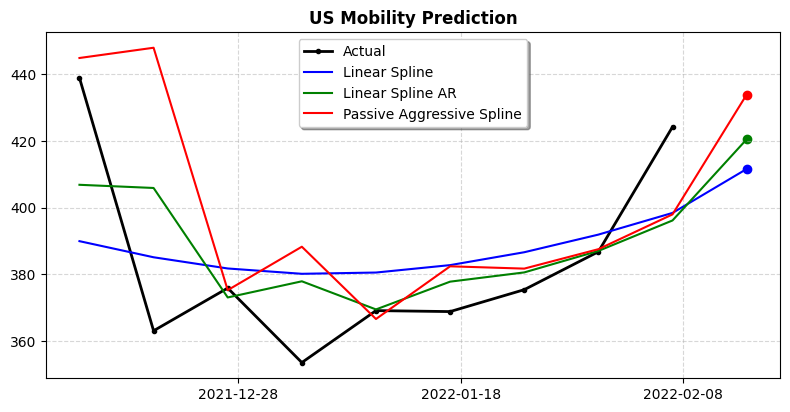

In [25]:
# ---------------------------------------------- VISUALIZATION PREDICTION
fig, ax = plt.subplots(figsize=(8, 4))

plt.plot(X_online['date'], X_online['total'], color='black', linewidth=2, label='Actual', marker='.')

plt.plot(y_lsm_total_pred['date'], y_lsm_total_pred['pred'], label='Linear Spline', color='blue')
plt.scatter(y_lsm_pred['date'][-1], y_lsm_pred['pred'][-1], color='blue', marker='o')

plt.plot(y_lsm_ar_total_pred['date'], y_lsm_ar_total_pred['pred'], label='Linear Spline AR', color='green')
plt.scatter(y_lsm_ar_pred['date'][-1], y_lsm_ar_pred['pred'][-1], color='green', marker='o')

plt.plot(y_pa_sm_total_pred['date'], y_pa_sm_total_pred['pred'], label='Passive Aggressive Spline', color='red')
plt.scatter(y_pa_sm_pred['date'][-1], y_pa_sm_pred['pred'][-1], color='red', marker='o')

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=3)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.legend(shadow=True, loc='upper center')
plt.tight_layout()
plt.grid(linestyle='--', alpha=0.5)

plt.title('US Mobility Prediction', fontweight='bold')


# Conclusions
* As expected **Linear Spline** is the model less reactive to past observation and smoother since depends only on calendar.
* By costruction **Passive Aggressive Linear Model** to take more in account the error committed in the last observation. This means that the model is more reactive but also more exposed to overfitting
* Among the three models I opt for the **Linear Spline AR** model
* In general forecasts are not really informative since models moslty rely on previous observation and no prediction interval is provided.

#### Next developments
* Spline models are white box, one can make explicit the contribution of each spline for each sample. I didn't have time ti implement it.
* Conformal calibraiton to produce prediction intervals (This would be my *must-have* feature I would implement first also because model agnostic).
* Multistep forecast (leadtime conditioning via embedding)
* Hierachical reconciliation model